# Phase 1 - Ingestion and Cleaning

In the Phase 2 of the Case Study, we will carry out the following steps:
  - Ingest raw downloaded data
  - Output a combined dataset ready for analysis and modeling

In [1]:
import pandas as pd
import os
from sys import platform
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pickle
import seaborn

In [2]:
# A helper function that you'll be using while reading the raw files
def is_integer(x):
    '''
    This function returns True if x is an integer, and False otherwise
    '''
    try:
        return (int(x) == float(x))
    except:
        return False

## Parameters

In [3]:
# Define the directories that contain the files downloaded
dir_cs = "/Users/leoli/Desktop/cmu ml/case_study/2003_download" # path to the directory where all the *.csv.zip files are located

# Define the output path for the pickle
pickle_file = "/Users/leoli/Desktop/cmu ml/case_study/" + "clean_data.pickle" # path to save cleaned data

In [4]:
# Identify the columns we'll be keeping from the dataset
cols_to_pick = ['id', 'loan_amnt', 'funded_amnt', 'term', 'int_rate', 'grade', 'emp_length', 'home_ownership',
'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'open_acc', 'pub_rec', 'fico_range_high',
'fico_range_low', 'revol_bal', 'revol_util', 'total_pymnt', 'recoveries'] # list of features to use for this study as indicated in the handout

### date_cols is given, but feature 'last_pymnt_d' is not one of those features in our PDF ####
### I add it to our needed colun and we may change it later
cols_to_pick += ['last_pymnt_d']



# Identify the type of each of these column based on your CS-Phase 1 response
float_cols = ['loan_amnt', 'funded_amnt','annual_inc', 'dti', 'delinq_2yrs','open_acc', 'pub_rec', 'fico_range_high', 'fico_range_low', 'revol_bal', 'total_pymnt', 'recoveries']
cat_cols = ['term', 'grade','emp_length', 'home_ownership', 'verification_status','loan_status', 'purpose'] # categorical features
perc_cols = ['int_rate', 'revol_util']
date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d']

# Ensure that we have types for every column
assert set(cols_to_pick) - set(float_cols) - set(cat_cols) - set(perc_cols) - set(date_cols) == set(["id"])

In [5]:
# Some of the columns selected will not be used directly in the model,
# but will be used to generate other features.
#
# Create variables specifying the features that will be used

# All categorical columns other than "loan_status" will be used as
# discrete features

discrete_features = list(set(cat_cols) - set(["loan_status"]))

# All numeric columns will be used as continuous features
continuous_features = list(float_cols + perc_cols)

## Ingestion
Ingest the data files from both sets, perform consistency checks, and prepare one single file for each set

In [6]:
def ingest_files(directory):
    '''
    This function will ingest every file in the specified directory
    into a pandas dataframe. It will return a dictionary containing
    these dataframes, keyed by the file name.
    
    We assume the directory contains files directly downloaded from
    the link given in the handout, and *only* those files. Thus, we 
    assume the files are zipped (pd.read_csv can read zipped files) 
    and we assume the first line in each file needs to be skipped.
    
    Note that each file will be read *without* formatting
    '''
    
    # If the directory has no trailing slash, add one
    if directory[-1] != "/":
        directory += "/"
    
    all_files = os.listdir(directory) # get list of all files from the directory
    # Some Mac user may have '.DS_Store' file, delete it here
#     all_files.remove('.DS_Store')
    output = {}
    
    print("Directory " + directory + " has " + str(len(all_files)) + " files:")
    for i in all_files:
        print("    Reading file " + i)
        output[i] = pd.read_csv(directory + i, dtype=str, skiprows=1) # read each with dtype='str' and skip_rows =1
        
        # Some of the files have "summary" lines that, for example
        # read "Total number of loans number in Policy 1: ....."
        # To remove those lines, find any lines with non-integer IDs
        # and remove them
        
        invalid_rows = output[i]['id'].str.isdigit()==False # mask rows that have non-integer IDs. Use is_integer method
        if invalid_rows.sum() > 0:
            print("Found " + str(invalid_rows.sum()) + " invalid rows which were removed")
            output[i] = output[i].loc[output[i]['id'].str.isdigit()] # remove invalid rows
    
    return output # return dictionary of dataframe

In [7]:
# Ingest the set of files we downloaded using the defined method "ingest_files"
files_cs = ingest_files(dir_cs) # dictioary of (filename, dataframe) as (key, value)

Directory /Users/leoli/Desktop/cmu ml/case_study/2003_download/ has 20 files:
    Reading file LoanStats_securev1_2019Q4.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q3.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q2.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats3a_securev1.csv.zip
Found 3 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats3d_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q3.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2018Q4.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q2.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanS

### Combine the files

In [8]:
data_cs = pd.concat(files_cs.values()).reset_index(drop=True) # combine "files_cs" into a pandas dataframe
              # resent index with drop = True

## Prepare Final Dataset

In [9]:
# Keep only the columns of interest from 'data_cs'
final_data = data_cs[cols_to_pick]

In [10]:
print("Starting with " + str(len(final_data)) + " rows")

Starting with 2777776 rows


### Typecast the columns

In [11]:
# Remember that we read the data as string (without any formatting). 
# Now we would typecast the columns based on feature types which you found out in CS Phase 1

for i in float_cols:
    final_data[i] = final_data[i].astype(float) # typecast float columns

/var/folders/f9/6w5f65hs37q5f3byxvq7rqc00000gn/T/ipykernel_2854/1286980223.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data[i] = final_data[i].astype(float) # typecast float columns


In [12]:
def clean_perc(x):
    if pd.isnull(x):
        return np.nan
    else:
        return float(x.strip()[:-1])

for i in perc_cols:
    final_data[i] = final_data[i].apply(clean_perc) # apply clean_perc to percentage columns

/var/folders/f9/6w5f65hs37q5f3byxvq7rqc00000gn/T/ipykernel_2854/255568752.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data[i] = final_data[i].apply(clean_perc) # apply clean_perc to percentage columns


In [13]:
def clean_date(x):
    if pd.isnull(x):
        return None
    else:
        return datetime.datetime.strptime( x, "%b-%Y").date()

for i in date_cols:
    final_data[i] = final_data[i].apply(clean_date) # typecast date cloumns to datatime using clean_date

/var/folders/f9/6w5f65hs37q5f3byxvq7rqc00000gn/T/ipykernel_2854/2653851960.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data[i] = final_data[i].apply(clean_date) # typecast date cloumns to datatime using clean_date


In [14]:
for i in cat_cols:
    # Only found Nan in 'emp_length' actually
    final_data[i] = final_data[i].replace({np.nan:None}) # for categorical features if the value is null/empty set it to None

/var/folders/f9/6w5f65hs37q5f3byxvq7rqc00000gn/T/ipykernel_2854/983176599.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data[i] = final_data[i].replace({np.nan:None}) # for categorical features if the value is null/empty set it to None


## Calculate returns for each loan

In [15]:
# Define the names of the four returns we'll be calculating as described in Q.6
# ret_PESS: Pessimistic return
# ret_OPT: Optimistic return
# ret_INTa, ret_INTb: Method3 at two differnt values of "i"
ret_cols = ["ret_PESS", "ret_OPT", "ret_INTa", "ret_INTb"]

In [16]:
# Remove all rows for loans that were paid back on the days they were issued
final_data['loan_length'] = (final_data.last_pymnt_d - final_data.issue_d) / np.timedelta64(1, 'M')
n_rows = len(final_data)

final_data = final_data[final_data['loan_length'] != 0] # select rows where loan_length is not 0. 

print("Removed " + str(n_rows - len(final_data)) + " rows")

/var/folders/f9/6w5f65hs37q5f3byxvq7rqc00000gn/T/ipykernel_2854/2265092521.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['loan_length'] = (final_data.last_pymnt_d - final_data.issue_d) / np.timedelta64(1, 'M')


Removed 12361 rows


### M1-Pessimistic Method

In [17]:
# Calculate the return using a simple annualized profit margin
# Pessimistic definition (Handout 6a.) (M1)

final_data['term_num'] = final_data.term.str.extract('(\d+)',expand=False).astype(int) # length of loan in months

# f (total amount invested): funded_amnt
# p (total amount repaid): total_pymnt
# t is the term length of the loan in months = term_num
# recoveries = post charge off gross recovery
# total_pymnt = Payments received to date for total amount funded

final_data['term_num'] = final_data.term.str.extract('(\d+)',expand=False).astype(int) # length of loan in months
final_data['ret_PESS'] = ((final_data['total_pymnt'] - final_data['funded_amnt']) / 
                          final_data['funded_amnt']) * (12 / final_data['term_num'])

### M2-Optimistic Method

In [18]:
# Assuming that if a loan gives a positive return, we can
# immediately find a similar loan to invest in; if the loan
# takes a loss, we use M1-pessimistic to compute the return

# f (total amount invested): funded_amnt
# p (total amount repaid): total_pymnt
# m is the actual length of the loan in months = loan_length
# m = epresents the length of the loan in months
# t is the term length of the loan in months = term_num
# t = number of months that each loan is intended to be paid off over
final_data['ret_OPT'] = ((final_data['total_pymnt'] - final_data['funded_amnt']) 
                         / final_data['funded_amnt']) * (12 / final_data['loan_length'])

final_data.loc[final_data.ret_OPT < 0,'ret_OPT'] = ((final_data['total_pymnt'] - final_data['funded_amnt']) 
                                                    / final_data['funded_amnt']) * (12 / final_data['term_num'])

### Method 3

In [19]:
# f (total amount invested): funded_amnt
# p (total amount repaid): total_pymnt

def ret_method_3(T, i):
    '''
    Given an investment time horizon (in months) and re-investment
    interest rate, calculate the return of each loan
    '''
    
    # Assuming that the total amount paid back was paid at equal
    # intervals during the duration of the loan, calculate the
    # size of each of these installment
    actual_installment = (final_data.total_pymnt - final_data.recoveries) / final_data.loan_length

    # Assuming the amount is immediately re-invested at the prime
    # rate, find the total amount of money we'll have by the end
    # of the loan
    cash_by_end_of_loan = actual_installment * ((1-(1+i)**final_data['loan_length'])/(1-(1+i))) 
    # compute the quantity given in [] in eq.2.3 of handout
    
    cash_by_end_of_loan = cash_by_end_of_loan + final_data.recoveries
    
    # Assuming that cash is then re-invested at the prime rate,
    # with monthly re-investment, until T months from the start
    # of the loan
    remaining_months = T - final_data['loan_length']
    final_return = cash_by_end_of_loan * (1+i)**remaining_months - final_data['funded_amnt'] 

    # Find the percentage return
    ret_val = (12/T) * final_return * 1 / final_data['funded_amnt']
    return ret_val

In [20]:
final_data['ret_INTa'] = ret_method_3(60, 0.023) # call ret_method_3 with T=60, i=0.023
final_data['ret_INTb'] = ret_method_3(60, 0.04) # call ret_method_3 with T=60, i=0.04

### Visualize the variables

In [21]:
def visualize_float_columns():
    '''
    This function visualizes Box-and-whisker plots for continuous variables
    '''
    
    # FLoat columns
    for i in float_cols + perc_cols + ret_cols:
#         plt.figure(figsize=(2, 2), dpi=50)
        seaborn.boxplot(final_data[i])

        # Print the three highest values
        highest_vals = final_data.nlargest(3, i)[i].tolist() # get 3 highest values
        
        smallest_val = min(final_data[i])
        
        plt.text(smallest_val, -0.3, highest_vals[0])
        plt.text(smallest_val, -0.2, highest_vals[1])
        plt.text(smallest_val, -0.1, highest_vals[2])

        plt.show()

In [22]:
def visualize_cat_columns():
    '''
    Lists the distinct values for categorical columns
    '''
    # Categorical columns 
    for i in cat_cols:
        print("field name: ", i) # print field name
        print("")
        print("number of distinct values: ", final_data[i].nunique()) # print number of distinct values
        print("")
        # for each distinct value print the number of occurances
        print(final_data[i].value_counts())    
        print("")
        print("")

In [23]:
def visualize_date_columns():
    '''
    This function visualizes a timeline density for dates
    '''
    
    # Date columns
    for i in date_cols:
        final_data[final_data[i].isnull() == False][i].apply(lambda x : str(x.year) +
                                                "-" + str(x.month)).value_counts(ascending = True).plot()
        plt.title(i + " (" + str(final_data[i].isnull().sum()) + " null values)")
        plt.show()

ValueError: Image size of 248379x413 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x480 with 1 Axes>

ValueError: Image size of 248379x413 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x480 with 1 Axes>

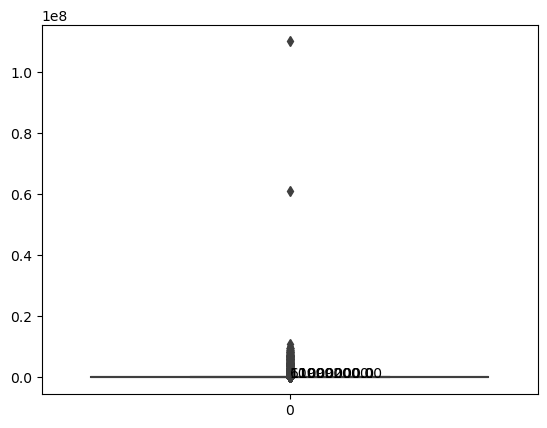

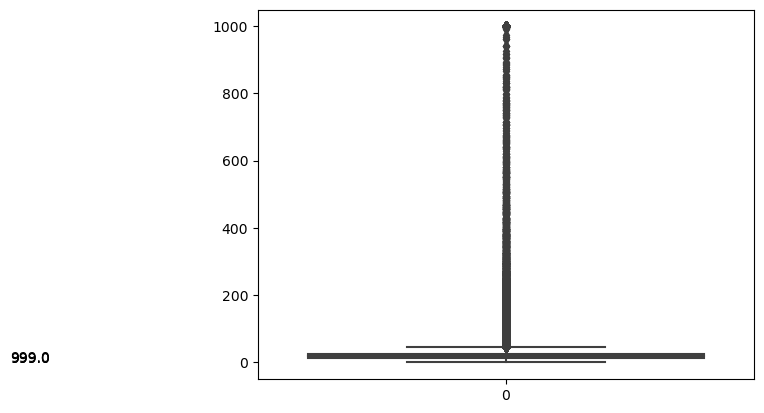

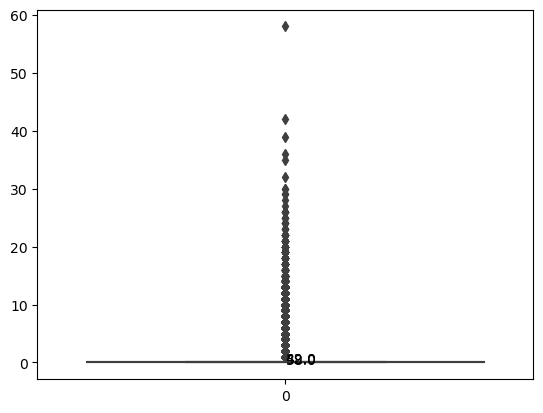

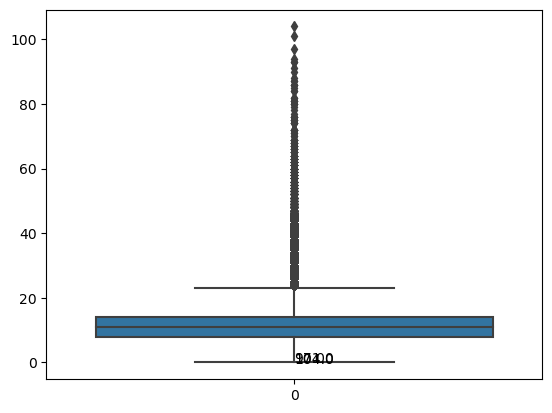

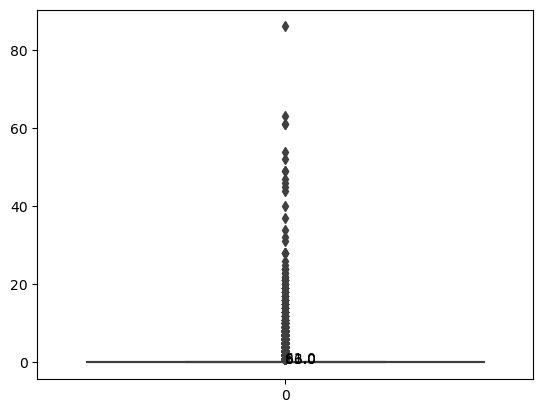

ValueError: Image size of 304888x1250 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x480 with 1 Axes>

ValueError: Image size of 302904x1248 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x480 with 1 Axes>

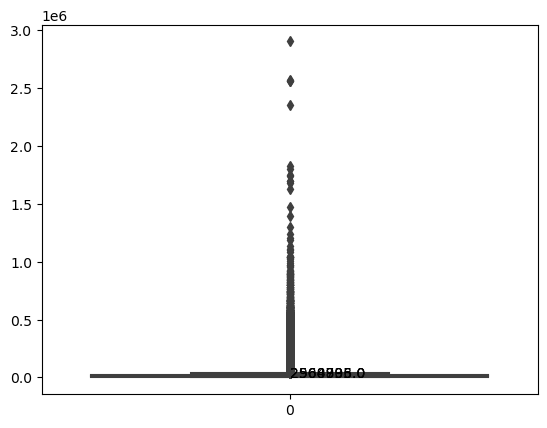

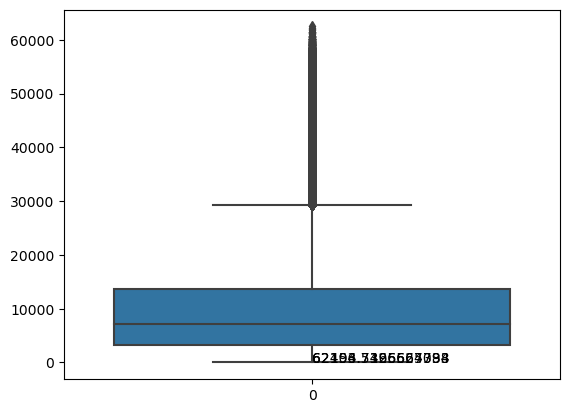

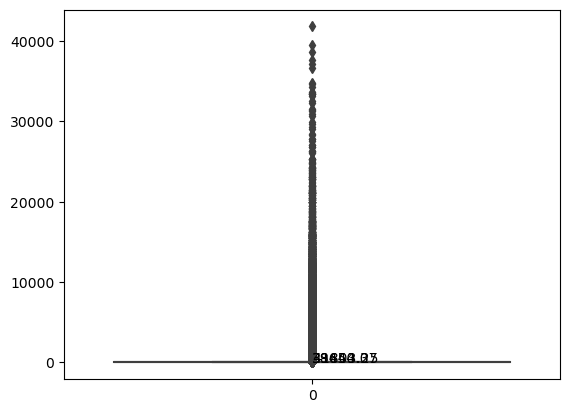

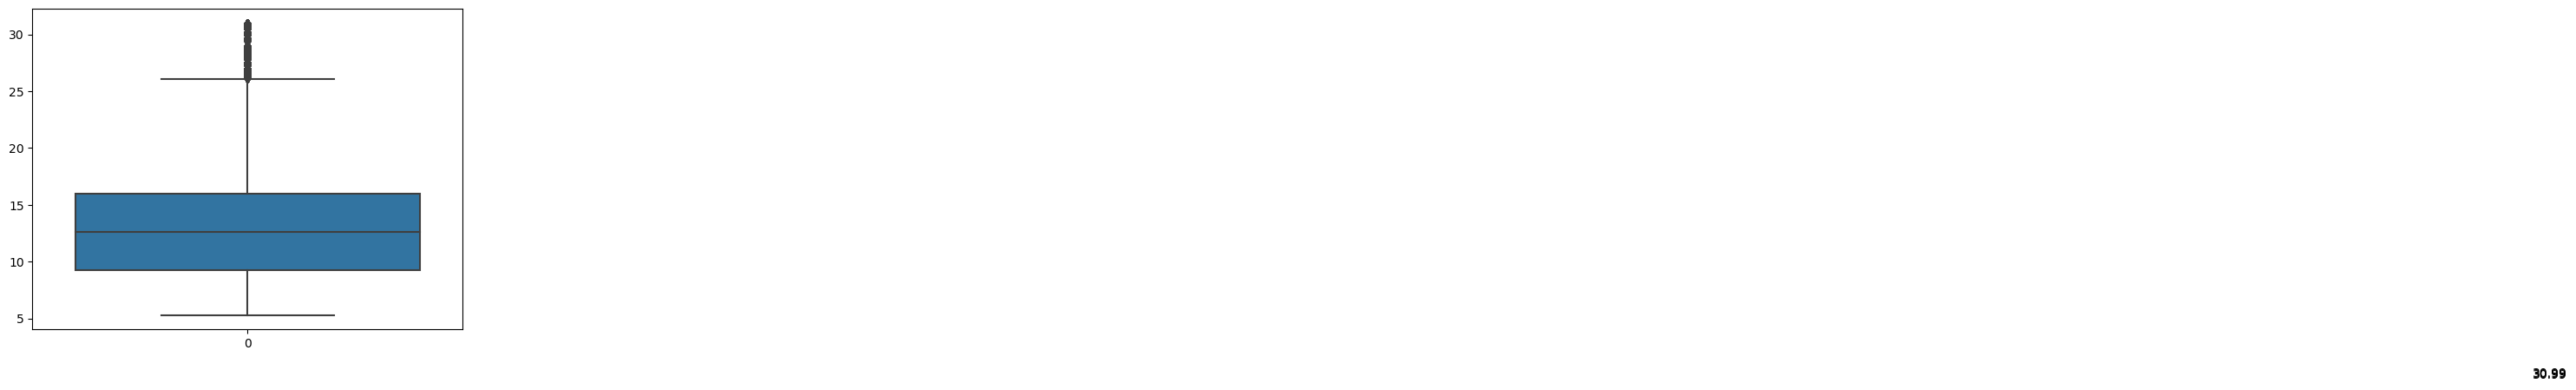

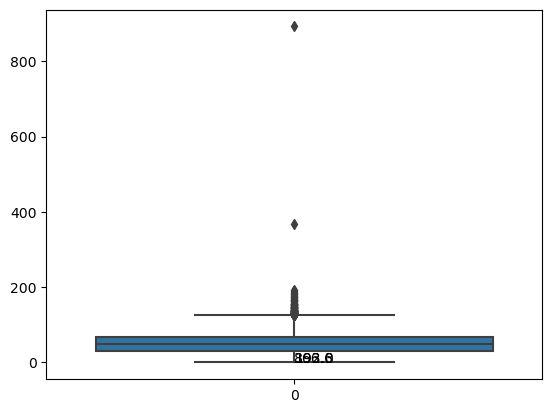

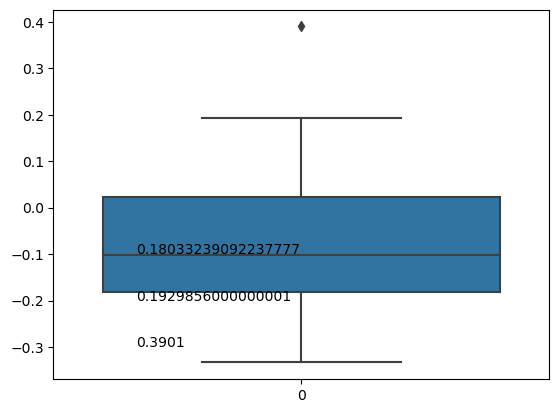

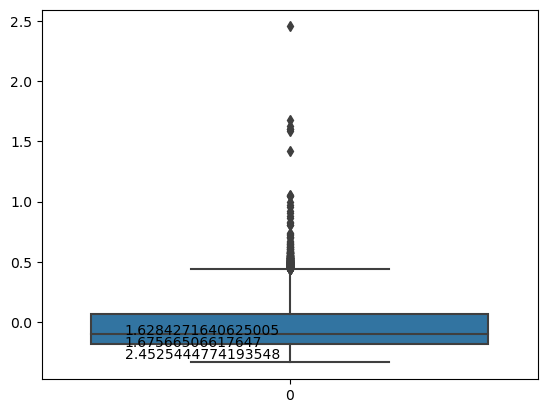

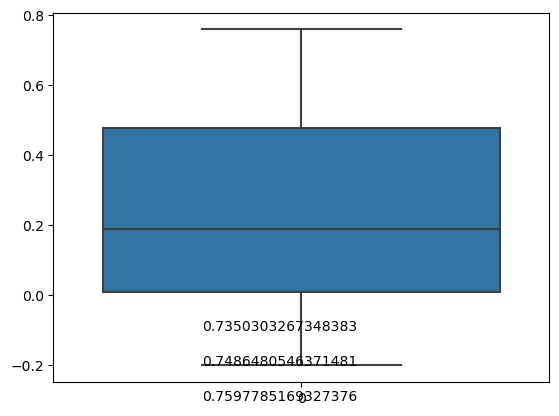

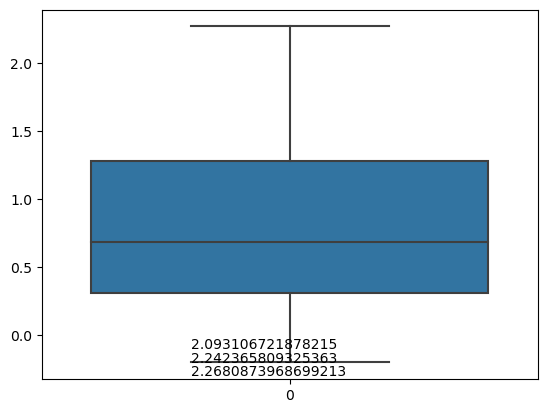

field name:  term

number of distinct values:  2

 36 months    1949756
 60 months     815659
Name: term, dtype: int64


field name:  grade

number of distinct values:  7

B    811304
C    768632
A    596277
D    397211
E    138329
F     41596
G     12066
Name: grade, dtype: int64


field name:  emp_length

number of distinct values:  11

10+ years    898370
< 1 year     253650
2 years      247379
3 years      219762
1 year       183001
5 years      171829
4 years      166566
6 years      123700
7 years      110120
8 years      107507
9 years       91449
Name: emp_length, dtype: int64


field name:  home_ownership

number of distinct values:  6

MORTGAGE    1359007
RENT        1090600
OWN          312178
ANY            3393
OTHER           182
NONE             55
Name: home_ownership, dtype: int64


field name:  verification_status

number of distinct values:  3

Source Verified    1066701
Not Verified        997623
Verified            701091
Name: verification_status, dtype: int64


f

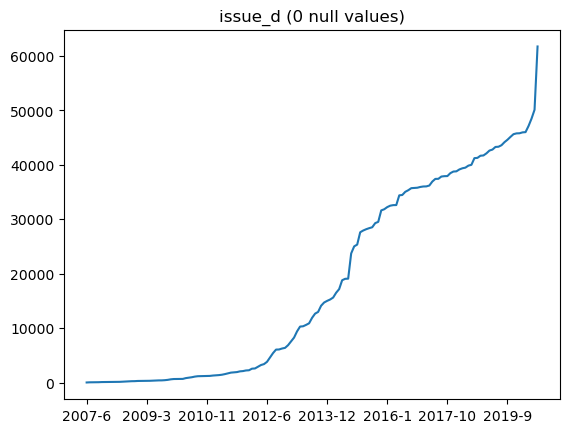

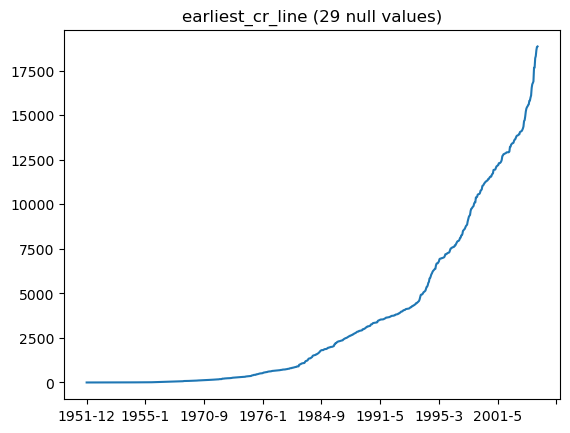

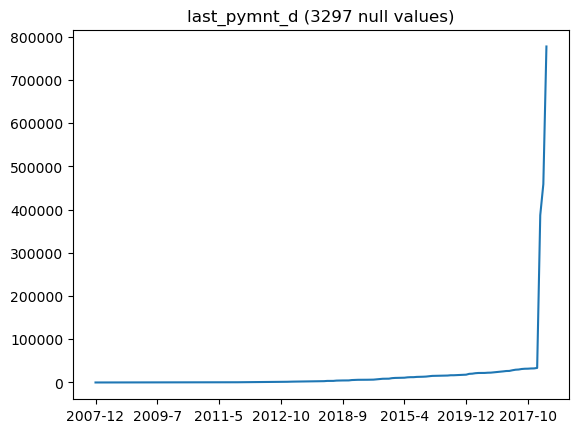

In [24]:
# visualize continuous features
visualize_float_columns()

# visulaize categorical features
visualize_cat_columns()

# visualize date columns
visualize_date_columns()

### Handle outliers

In [25]:
def detect_outliers():
    '''
    This function detect the outliers range based on box_plot quantile
    '''
    col_bounds = {}
    # FLoat columns
    for i in float_cols + perc_cols + ret_cols:
        Q1 = final_data[i].quantile(0.25)
        Q3 = final_data[i].quantile(0.75)
        multiplier=1.5
        IQR = Q3 - Q1
        
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        
        if lower_bound < 0:
            lower_bound = 0
        col_bounds[i] = {'lower_bound': lower_bound, 'upper_bound': upper_bound}
        print(f"The bounds for {i} is: lower Bound {lower_bound} , upper bound: {upper_bound}")
    return col_bounds

In [26]:
# There are quite a few outliers. 
# Please identify top-k (decide this based on the visualization) features where outliers are most obvious
n_rows = len(final_data)

self_defined_cols = ['ret_PESS','ret_OPT', 'ret_INTa', 'ret_INTb'] # those cols are calculated from other features, which should not be used as filter
drop_based_cols = float_cols + perc_cols + ret_cols
drop_based_cols = [col for col in drop_based_cols if col not in self_defined_cols]

col_bounds = detect_outliers()
for i in drop_based_cols:
    if col_bounds[i]['lower_bound'] != 0 or col_bounds[i]['upper_bound'] != 0:
        final_data = final_data[(final_data[i] >= col_bounds[i]['lower_bound']) & (final_data[i] <= col_bounds[i]['upper_bound'])]


    
# final_data = ... # remove outliers based 1st obvious feature
# final_data = ... # remove outliers based 2nd obvious feature
# ...
# final_data = ... # remove outliers based kth obvious feature

print("Removed " + str(n_rows - len(final_data)) + " rows")

The bounds for loan_amnt is: lower Bound 0 , upper bound: 38000.0
The bounds for funded_amnt is: lower Bound 0 , upper bound: 38000.0
The bounds for annual_inc is: lower Bound 0 , upper bound: 167000.0
The bounds for dti is: lower Bound 0 , upper bound: 43.945
The bounds for delinq_2yrs is: lower Bound 0.0 , upper bound: 0.0
The bounds for open_acc is: lower Bound 0 , upper bound: 23.0
The bounds for pub_rec is: lower Bound 0.0 , upper bound: 0.0
The bounds for fico_range_high is: lower Bound 619.0 , upper bound: 779.0
The bounds for fico_range_low is: lower Bound 615.0 , upper bound: 775.0
The bounds for revol_bal is: lower Bound 0 , upper bound: 42350.5
The bounds for total_pymnt is: lower Bound 0 , upper bound: 29309.844992704497
The bounds for recoveries is: lower Bound 0.0 , upper bound: 0.0
The bounds for int_rate is: lower Bound 0 , upper bound: 26.1
The bounds for revol_util is: lower Bound 0 , upper bound: 125.70000000000002
The bounds for ret_PESS is: lower Bound 0 , upper bo

In [27]:
# Remove all loans that are still current
n_rows = len(final_data)

final_data = final_data[final_data['loan_status'] != 'Current']

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 1216547 rows


In [28]:
# Only include loans isssued since 2010
n_rows = len(final_data)

start_date = datetime.date(2010, 1, 1)

final_data = final_data[final_data['issue_d'] >= start_date]

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 6883 rows


### Drop null values

In [29]:
# Deal with null values. We allow cateogrical variables to be null
# OTHER than grade, which is a particularly important categorical.
# All non-categorical variables must be non-null, and we drop
# rows that do not meet this requirement

required_cols = set(cols_to_pick) - set(cat_cols) - set(["id"])
required_cols.add("grade")

n_rows = len(final_data)

final_data = final_data.dropna(subset=required_cols) # drop rows that contain null based only on "required_cols"

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 2333 rows


### Visualize clean data

/Users/seancen/miniforge3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


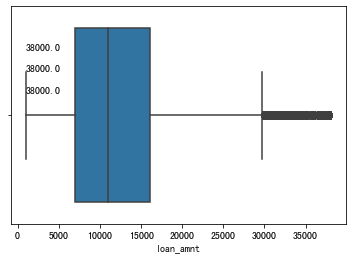

/Users/seancen/miniforge3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


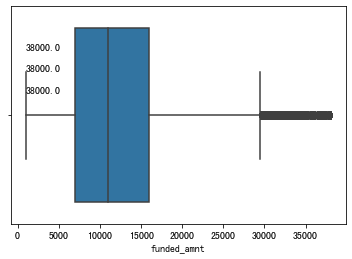

/Users/seancen/miniforge3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


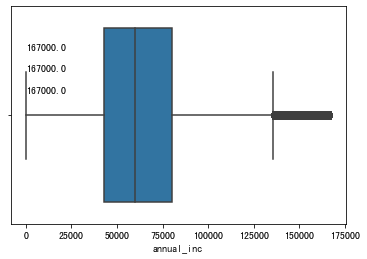

/Users/seancen/miniforge3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


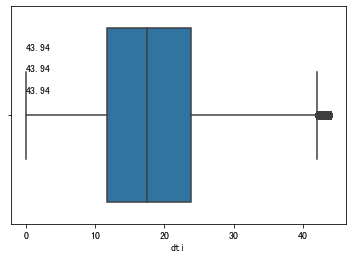

/Users/seancen/miniforge3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


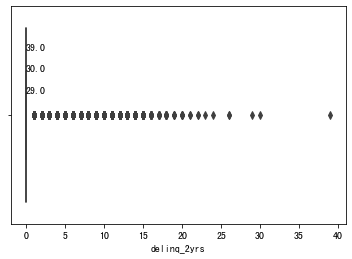

/Users/seancen/miniforge3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


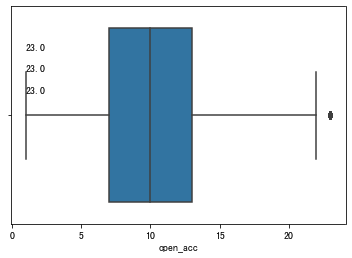

/Users/seancen/miniforge3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


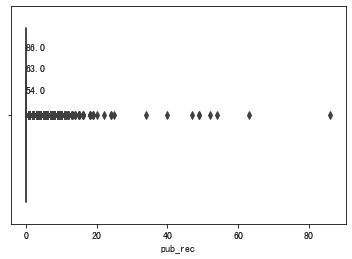

/Users/seancen/miniforge3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


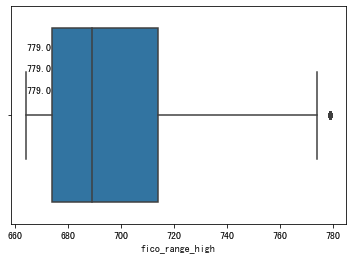

/Users/seancen/miniforge3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


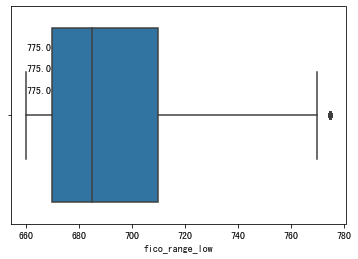

/Users/seancen/miniforge3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


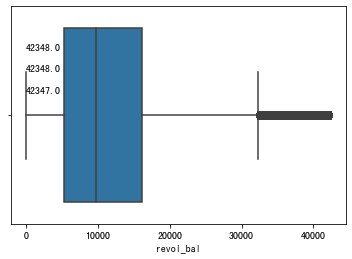

/Users/seancen/miniforge3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


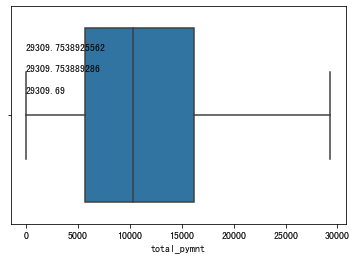

/Users/seancen/miniforge3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


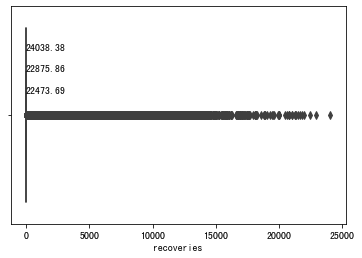

/Users/seancen/miniforge3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


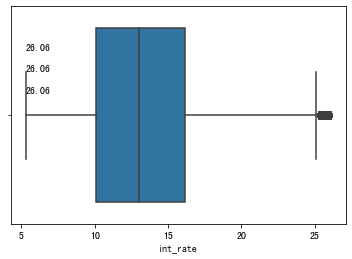

/Users/seancen/miniforge3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


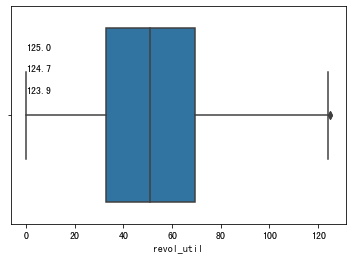

/Users/seancen/miniforge3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


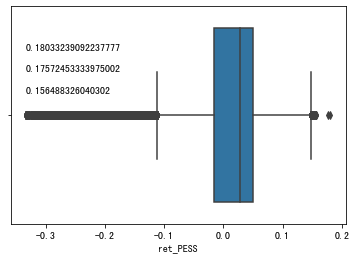

/Users/seancen/miniforge3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


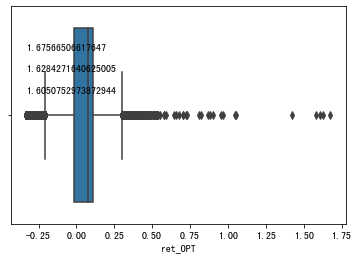

/Users/seancen/miniforge3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


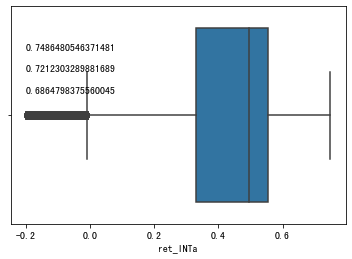

/Users/seancen/miniforge3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


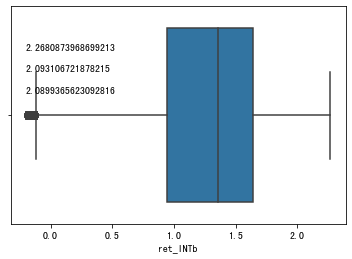

field name:  term

number of distinct values:  2

 36 months    732726
 60 months    201371
Name: term, dtype: int64


field name:  grade

number of distinct values:  7

B    278757
C    272205
D    152432
A    152205
E     60245
F     16040
G      2213
Name: grade, dtype: int64


field name:  emp_length

number of distinct values:  11

10+ years    287661
2 years       86794
< 1 year      77452
3 years       76800
1 year        63957
5 years       60381
4 years       57681
6 years       45231
7 years       42359
8 years       41591
9 years       33725
Name: emp_length, dtype: int64


field name:  home_ownership

number of distinct values:  6

MORTGAGE    428491
RENT        405482
OWN          99472
ANY            576
OTHER           41
NONE            35
Name: home_ownership, dtype: int64


field name:  verification_status

number of distinct values:  3

Source Verified    351198
Not Verified       325595
Verified           257304
Name: verification_status, dtype: int64


field name: 

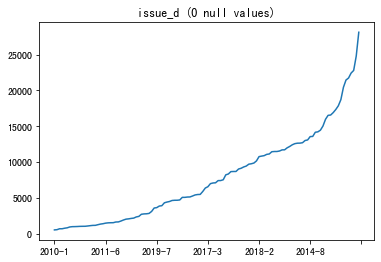

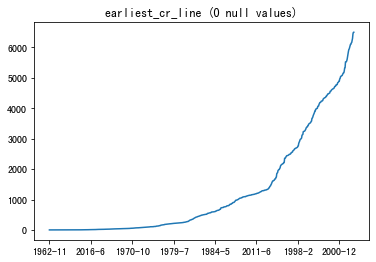

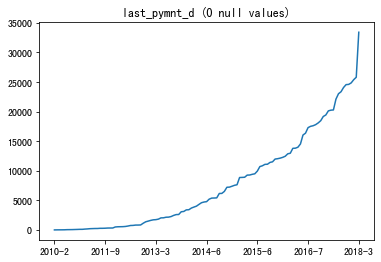

In [36]:
# Visualize the data again after cleaning

# visualize continuous features
visualize_float_columns()

# visulaize categorical features
visualize_cat_columns()

# visualize date columns
visualize_date_columns()

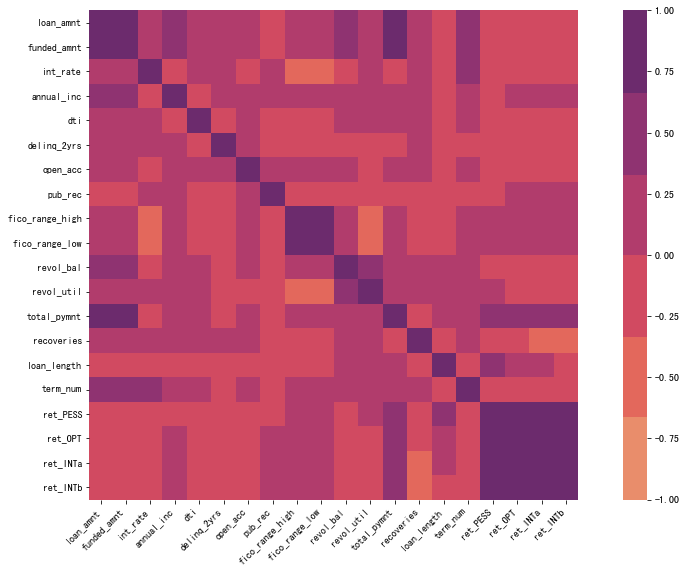

In [37]:
# Visualize the feature correlations
    # You can compute the correlation among features and display a heat-map of the matrix 
    # OR use sns scatter or pairplot
corr = final_data.corr()
plt.figure(figsize=(16,9))
ax = seaborn.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=seaborn.color_palette("flare"),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

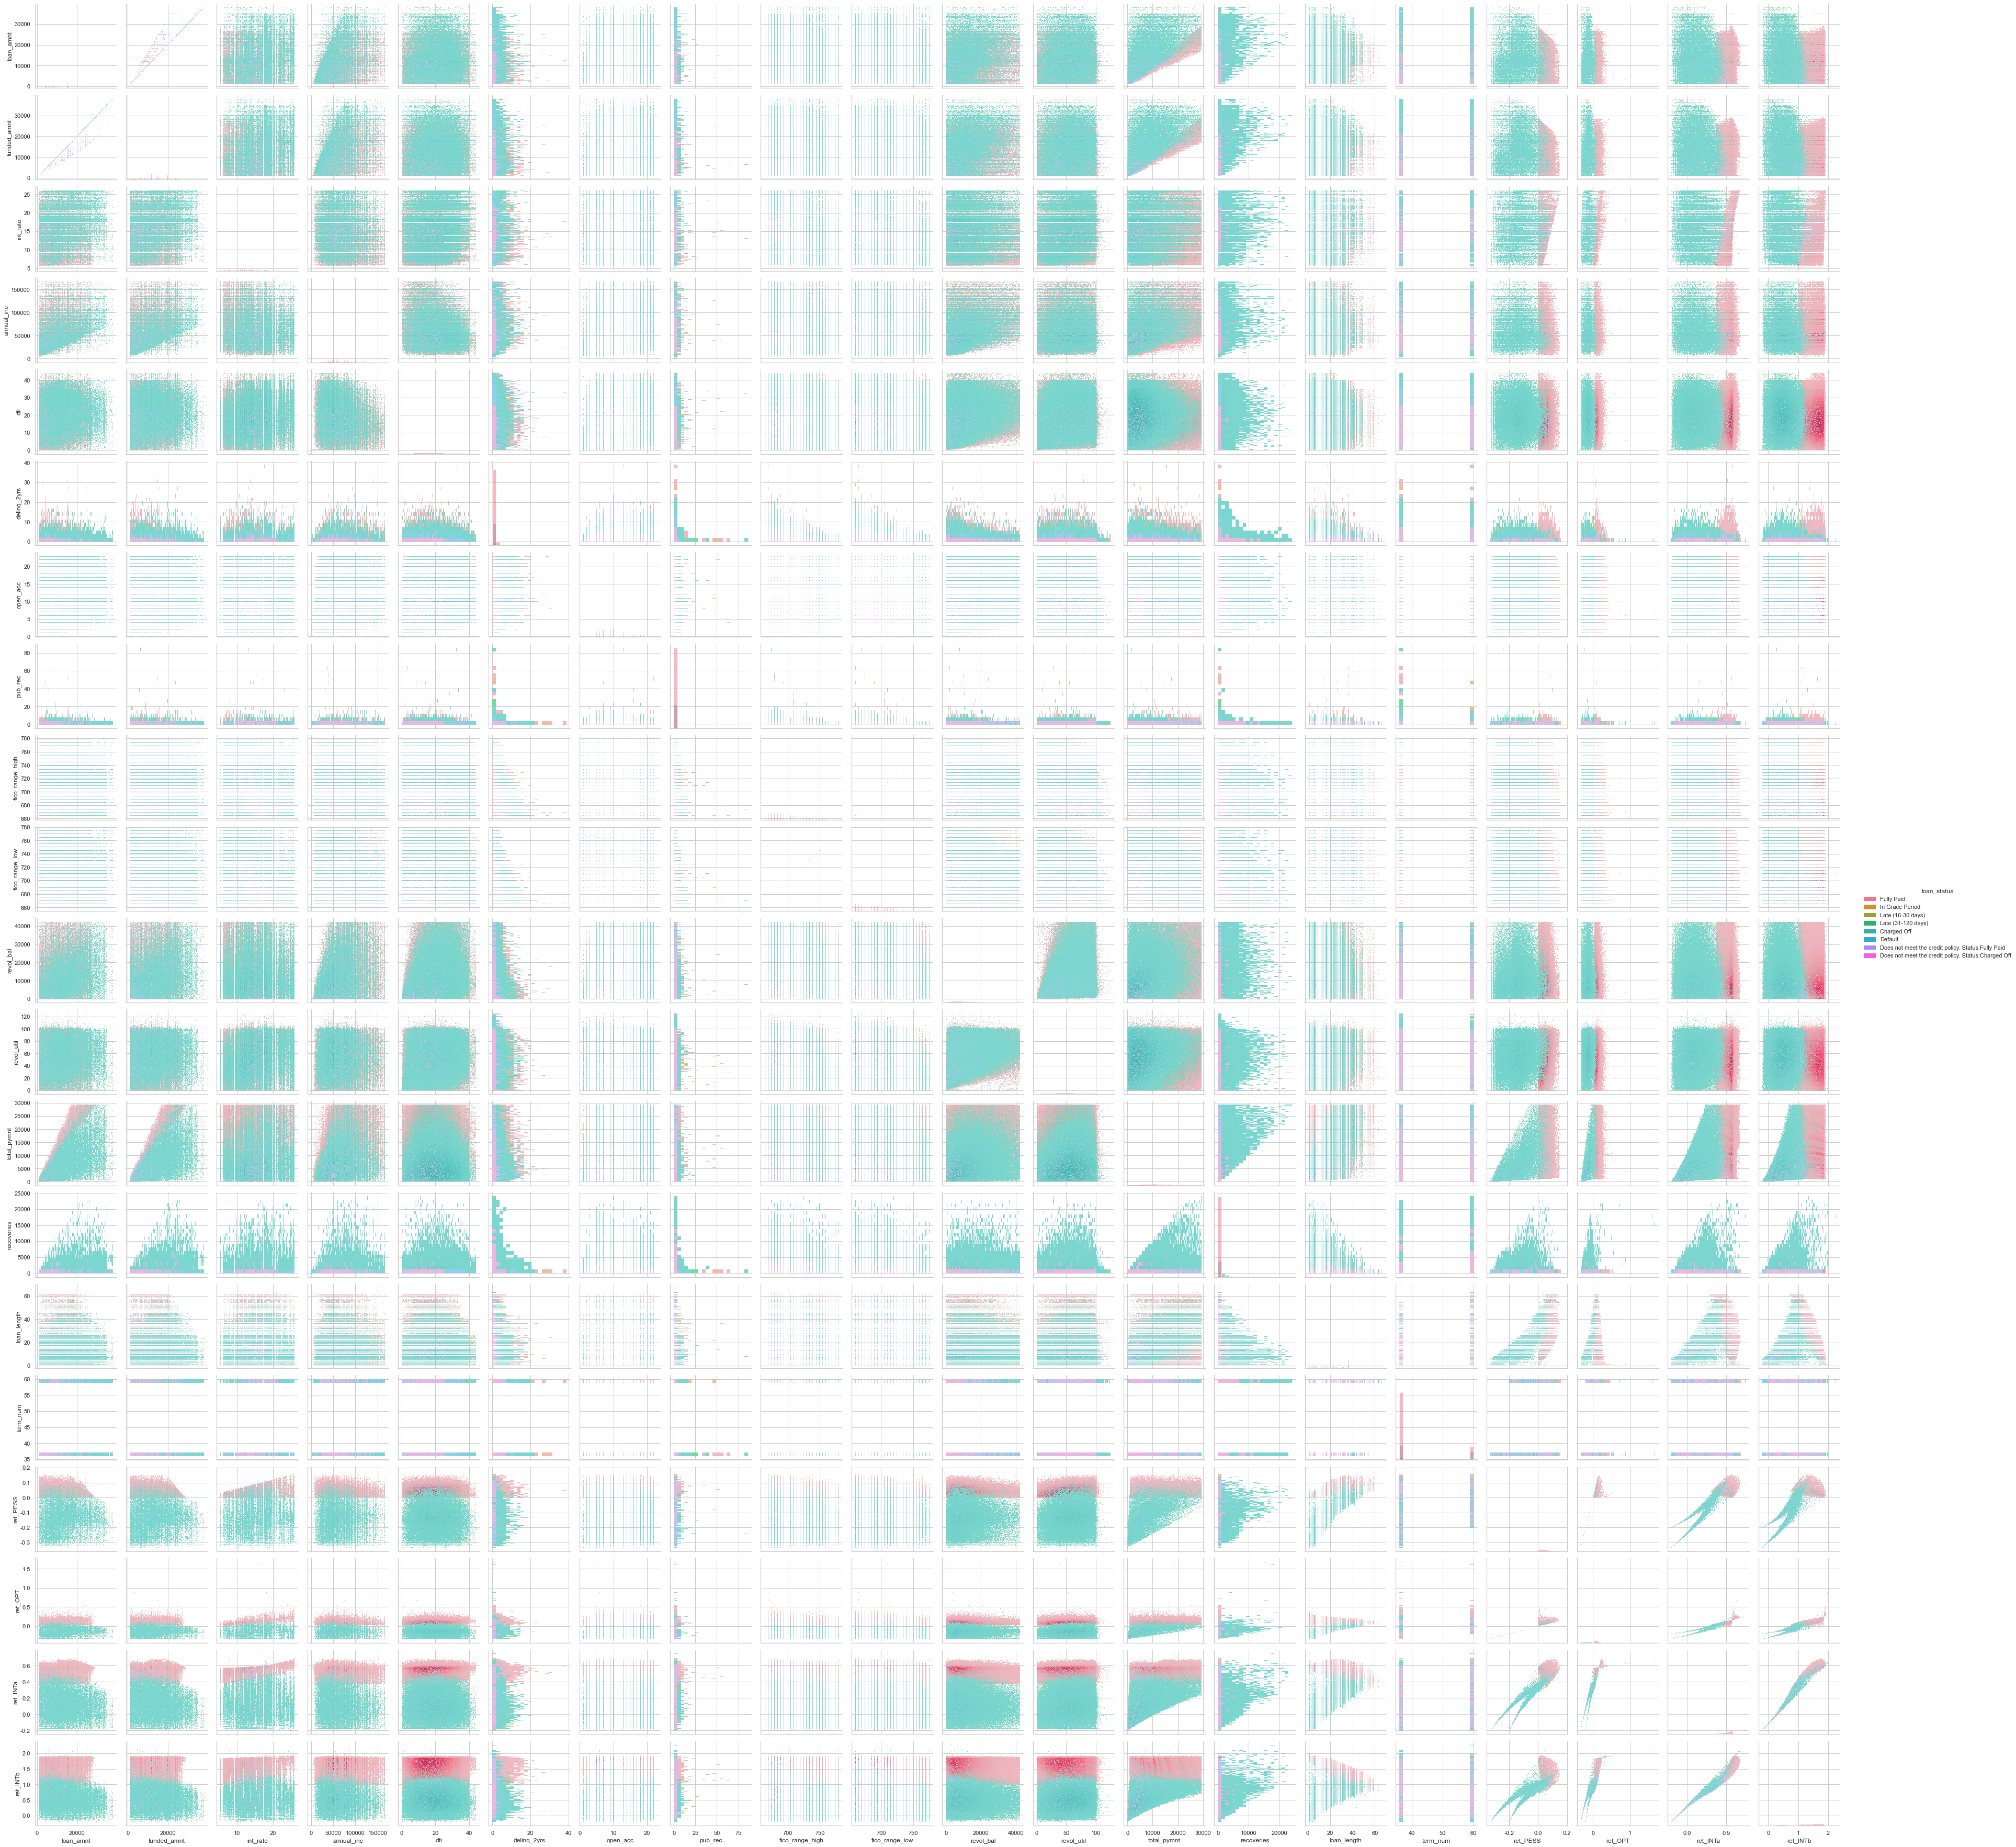

In [38]:
# Visualize relation between loan status and features
... # sns pairplot or scatter plot. Refer to recitations
seaborn.set(style="whitegrid")
seaborn.set_palette("flare")

seaborn.pairplot(data=final_data, hue='loan_status', kind='hist')

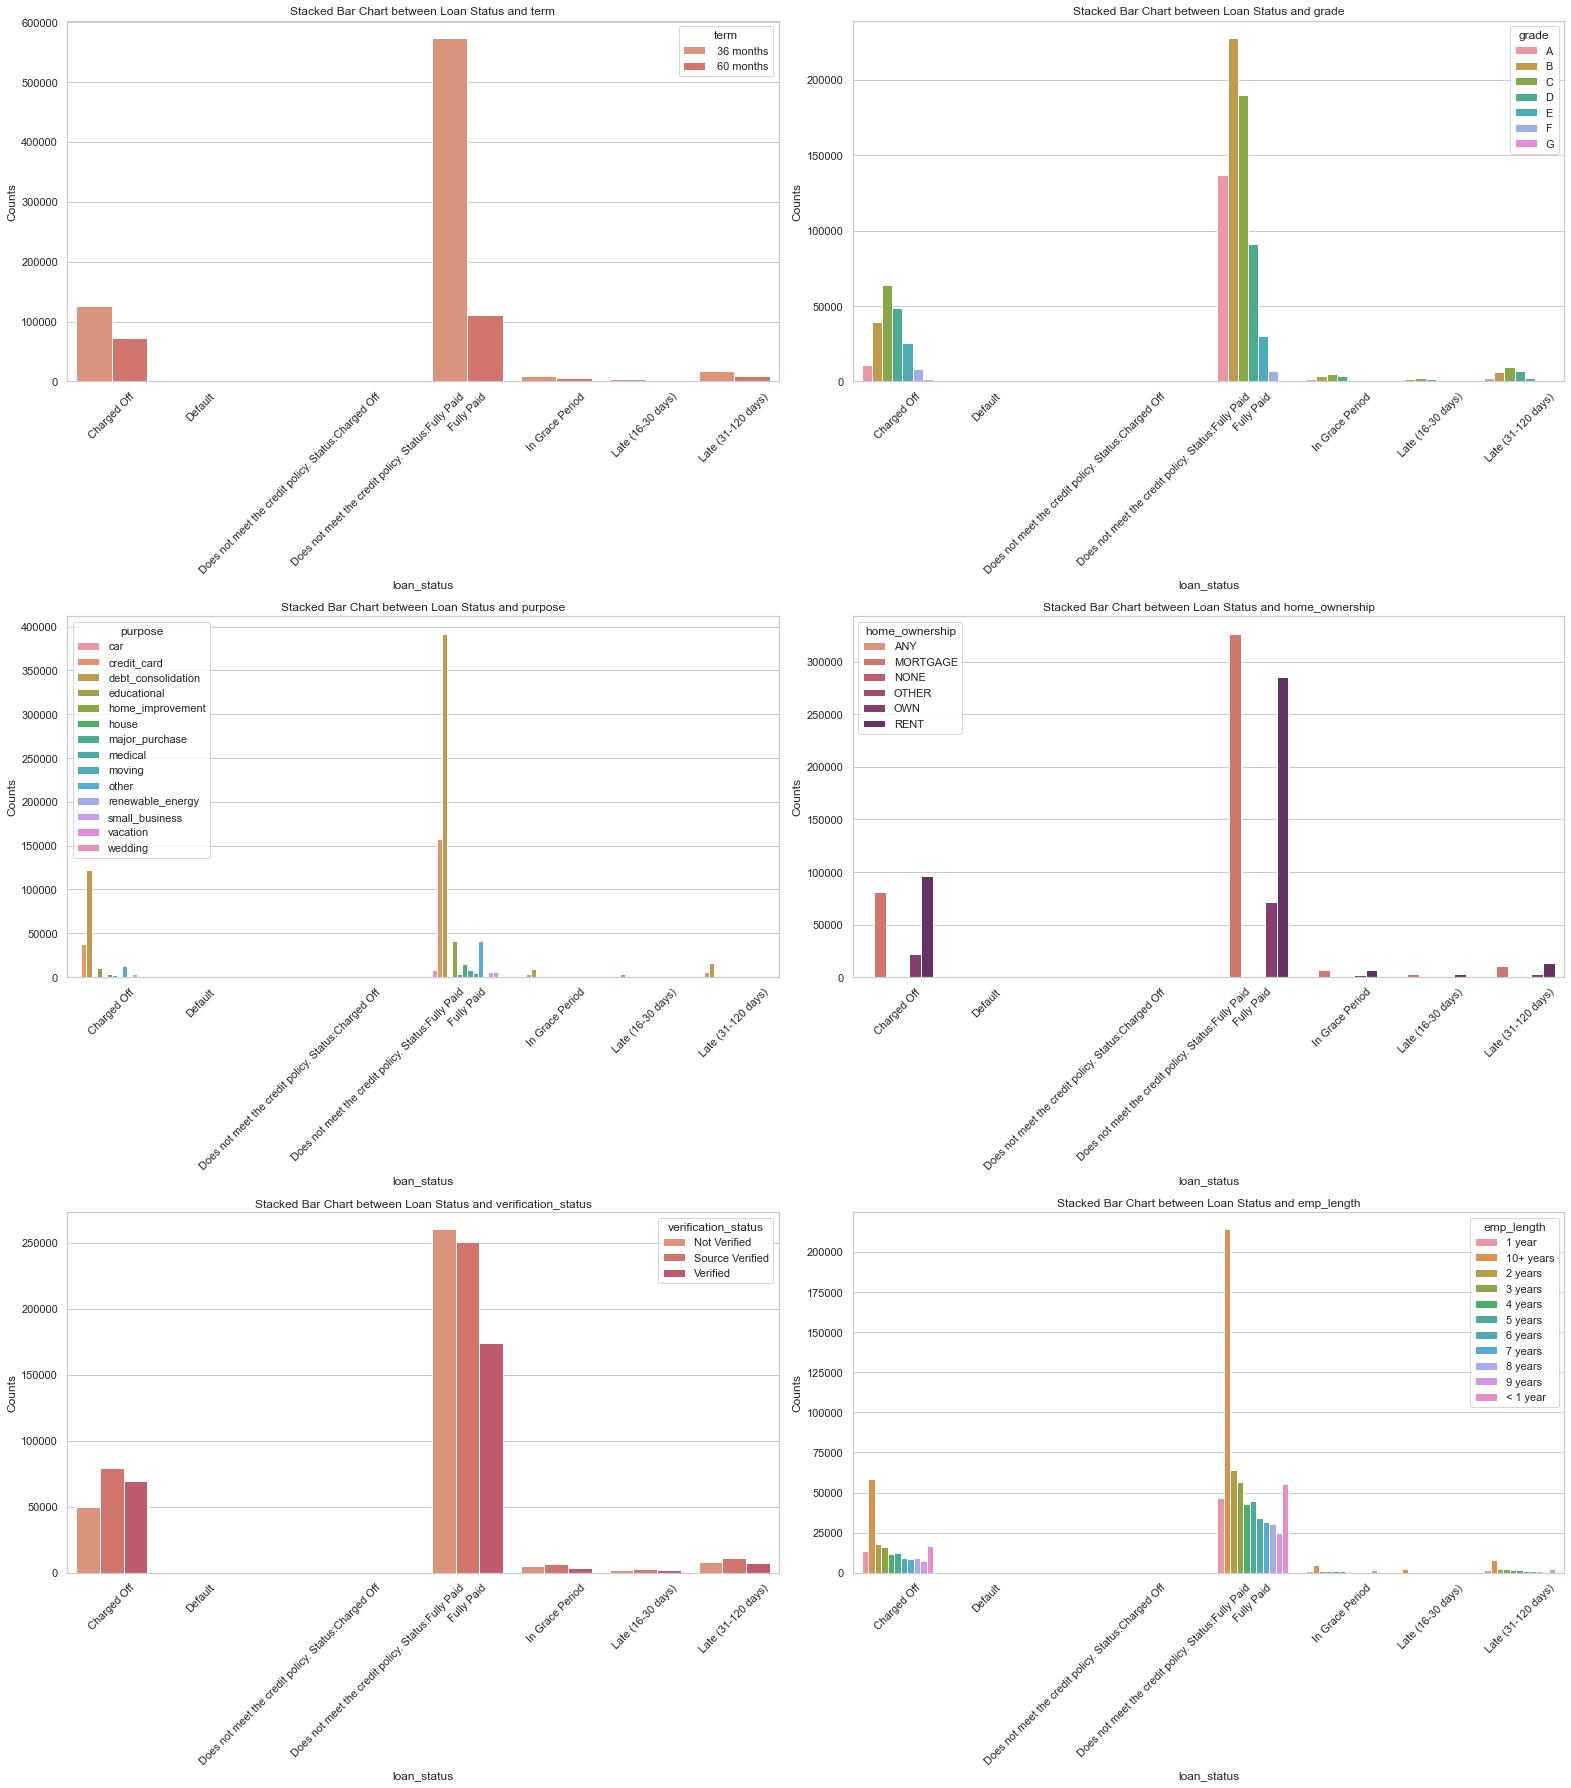

In [39]:
# Relationship between loan status and other discrete features
nrows = 3
ncols = 2

fig, axes = plt.subplots(nrows, ncols, figsize=(22, 25))

for i, feature in enumerate(discrete_features):
    row = i // ncols
    col = i % ncols

    df_count = final_data.groupby(['loan_status', feature]).size().reset_index(name='Counts')

    seaborn.barplot(data=df_count, x='loan_status', y='Counts', hue=feature, ax=axes[row, col])
    axes[row, col].set_title(f'Stacked Bar Chart between Loan Status and {feature}')

    axes[row, col].set_xticklabels(axes[row, col].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

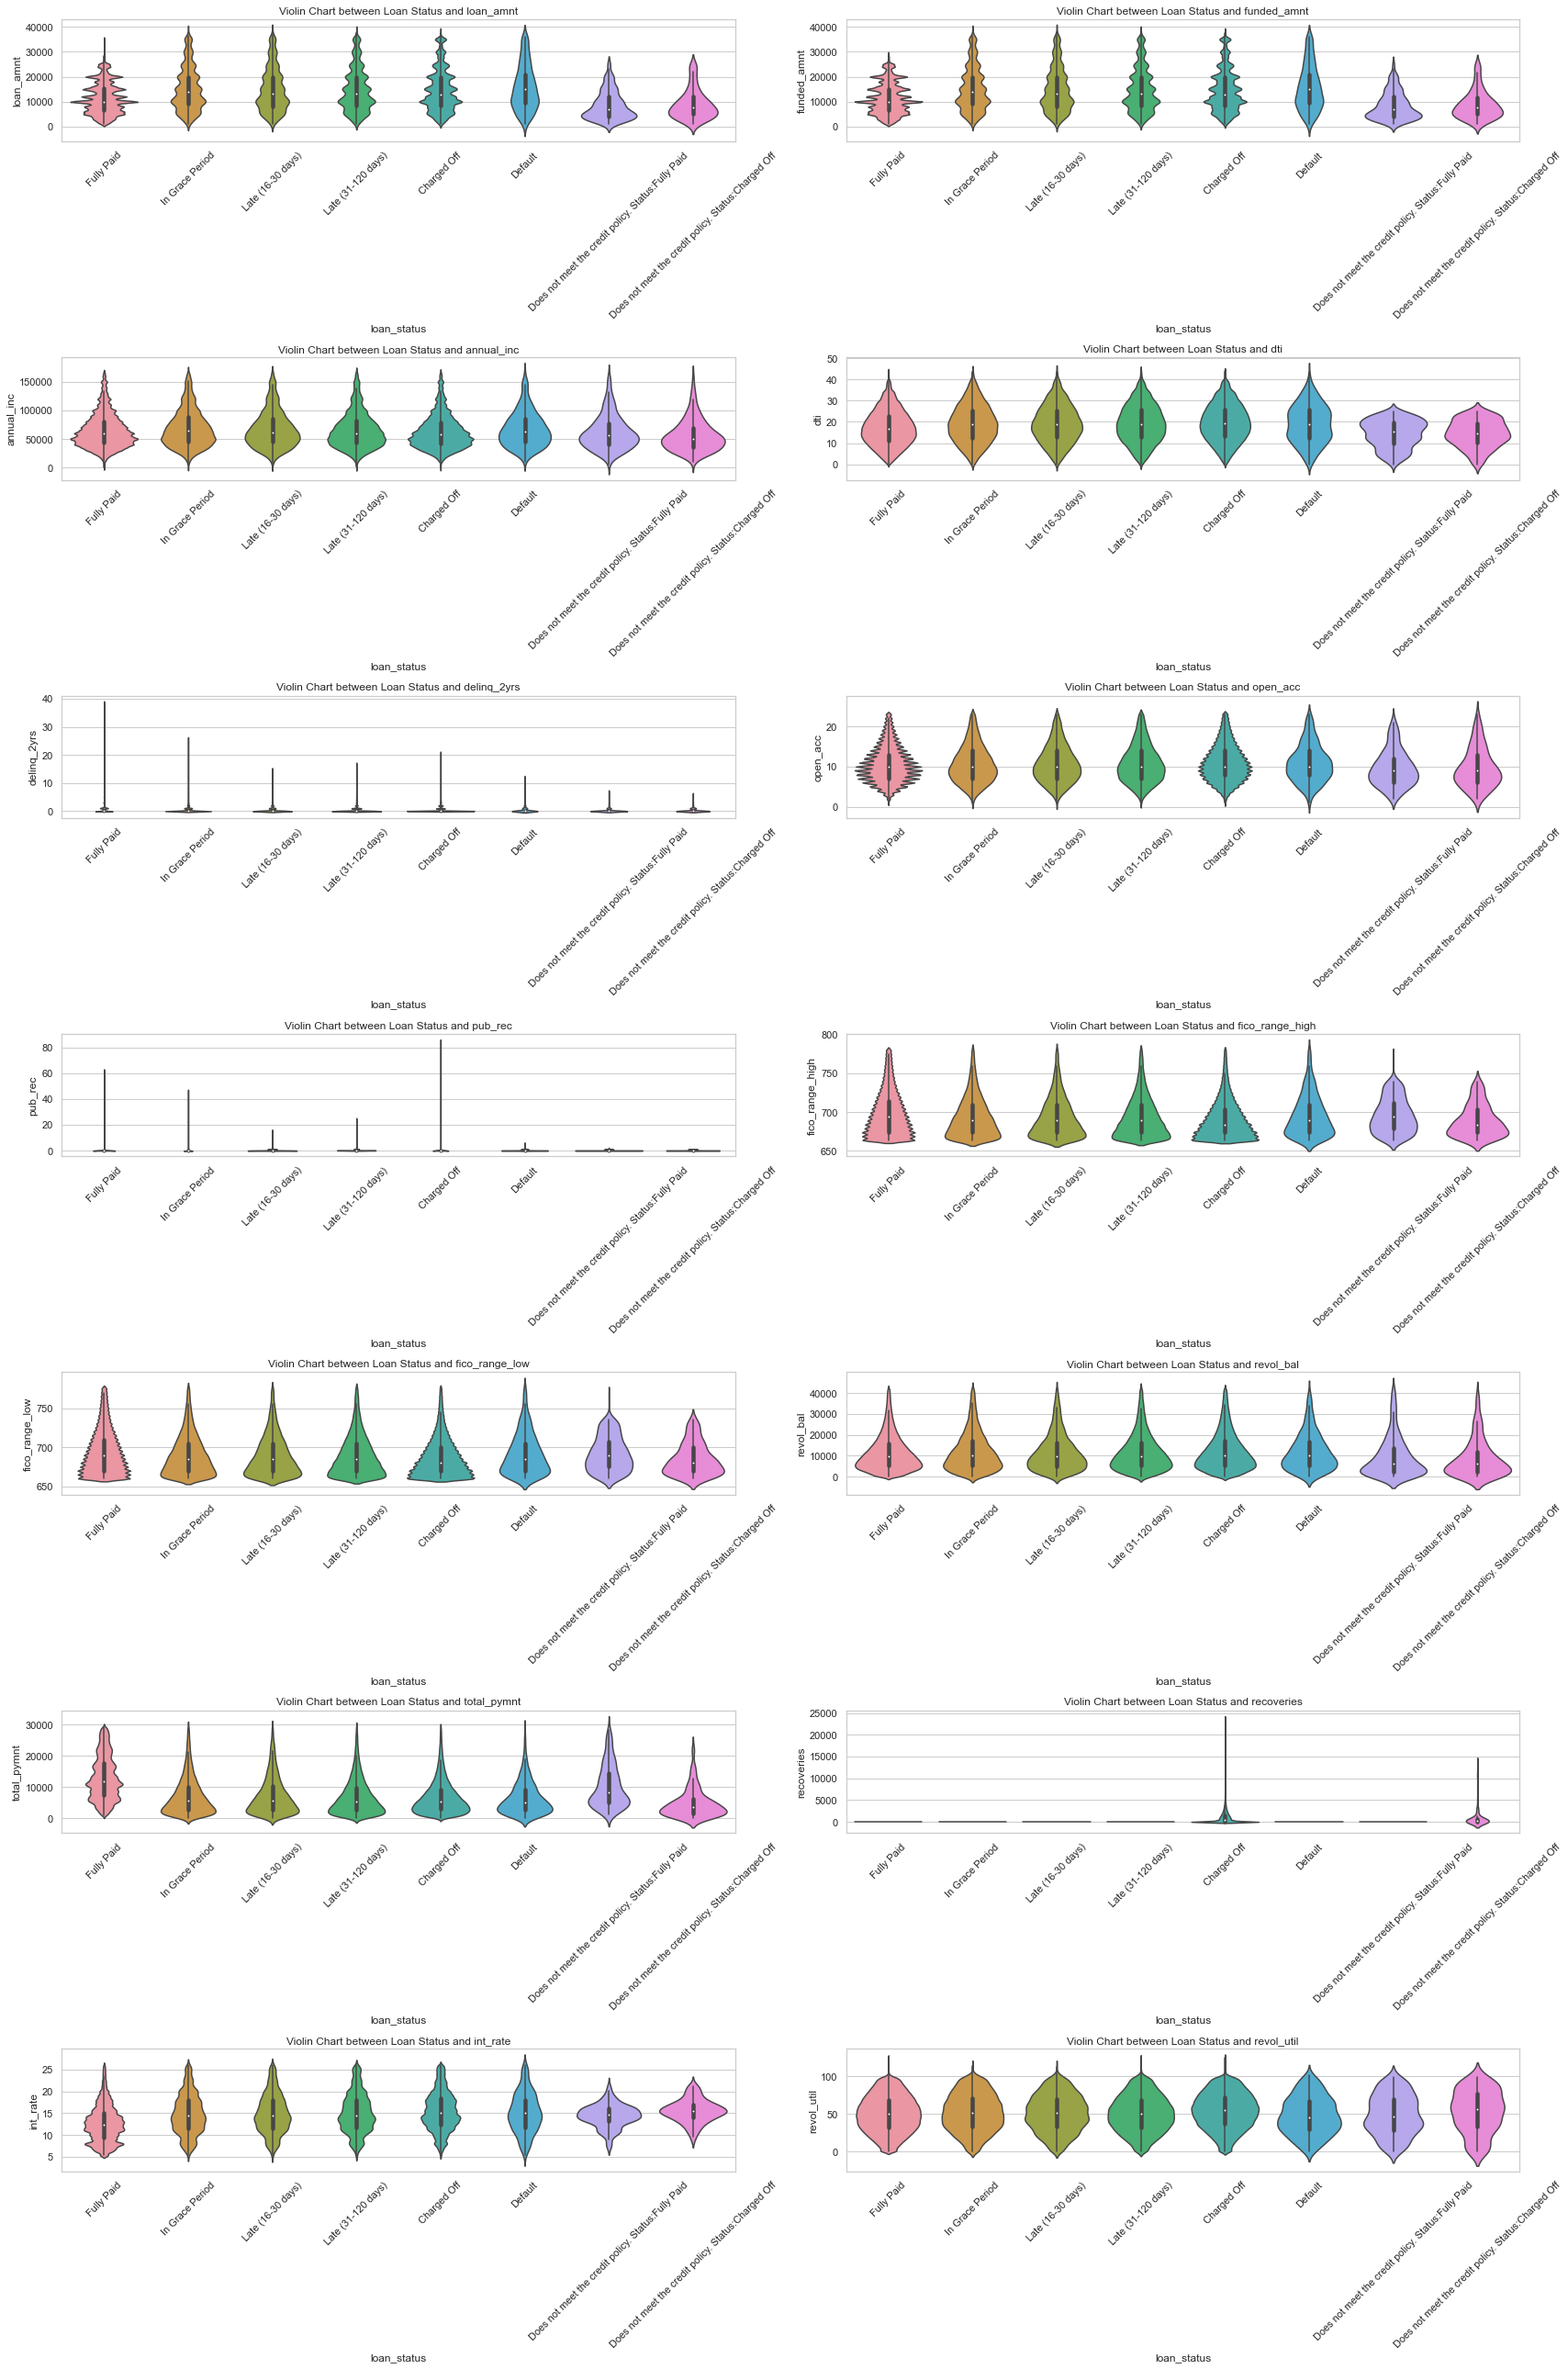

In [40]:
# Relationship between loan status and other continious features
nrows = 7
ncols = 2

fig, axes = plt.subplots(nrows, ncols, figsize=(24, 36))

for i, feature in enumerate(continuous_features):
    row = i // ncols
    col = i % ncols
    seaborn.violinplot(data=final_data, x='loan_status', y=feature, ax=axes[row, col], width= 0.8)
    axes[row, col].set_title(f'Violin Chart between Loan Status and {feature}')

    axes[row, col].set_xticklabels(axes[row, col].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

What do you observe after removing the outliers?

**For continuous features:**
    
**Data distribution:** After outlier removal, the data distribution becomes denser below the first quantile and above the third quantile.

**Top 3 highest values:** The top 3 highest values for each continuous feature become closer after removing outliers, indicating that the extreme values have been handled. For example, the top three highest values for feature ‘annual_inc’ are 110,000,000, 61,000,000, and 10,999,200 separately. After removing outliers, they all became 167,000.

**New 'outliers':** Although some data points become new 'outliers' after removing the original outliers, you choose to keep them to preserve the original data distribution, avoid data loss, and prevent overfitting.

**For categorical features:**

**Reduction in distinct values:** The number of distinct values for each categorical feature remains the same after outlier removal, indicating that the categories are preserved even after removing outliers.

**Change in category frequencies:** The frequencies of each category within the features have changed after removing outliers. For example, in the term feature, the count of '36 months' loans has reduced from 1,949,756 to 732,726, and the count of '60 months' loans has reduced from 815,659 to 201,371. This suggests that the overall distribution of categories has been affected by outlier removal.

**Proportional change:** The proportional change in category frequencies can also be observed. In the grade feature, the proportions of grades B and C were initially quite close (811,304 and 768,632, respectively). After outlier removal, the difference between these counts has narrowed (278,757 and 272,205, respectively).

**Relative ranking:** The relative ranking of categories within the features is mostly preserved after outlier removal. For instance, in the emp_length feature, the '10+ years' category remains the most frequent, and the '9 years' category remains the least frequent.

**For date features:**

It seems that after removing outliers, the date features' trends have become smoother, and the noise or fluctuations have decreased. This is a positive outcome because a less jagged trend allows for easier identification of patterns or seasonality in the data. At the same time, preserving the overall trend ensures that the main structure and relationships in the data are retained, which is crucial for modeling and analysis.


### Data Exploration
Solution to Q.7 from the handout

In [41]:
# Find the percentage of loans by grade, the default by grade,
# and the return of each grade
perc_by_grade = (final_data.grade.value_counts()*100/len(final_data)).sort_index()

default_by_grade = final_data.groupby("grade").apply(lambda x : (x.loan_status != "Fully Paid").sum()*100/len(x) )
ret_by_grade_OPT = final_data.groupby("grade").mean()['ret_OPT'] # average return for M2-Optimistic for each loan grade
ret_by_grade_PESS = final_data.groupby("grade").mean()['ret_PESS'] # average return for M1-Pessimistic for each loan grade
ret_by_grade_INTa = final_data.groupby("grade").mean()['ret_INTa'] # average return for M3
ret_by_grade_INTb = final_data.groupby("grade").mean()['ret_INTb'] # average return for M3
int_rate_by_grade = final_data.groupby("grade").mean()['int_rate'] # average interest rate for each grade

combined = pd.DataFrame(perc_by_grade)
combined.columns = ['perc_of_loans']
combined['perc_default'] = default_by_grade
combined['avg_int_rate'] = int_rate_by_grade
combined['return_OPT'] = ret_by_grade_OPT
combined['return_PESS'] = ret_by_grade_PESS
combined['return_INTa'] = ret_by_grade_INTa
combined['return_INTb'] = ret_by_grade_INTb

combined

perc_of_loans  perc_default  avg_int_rate  return_OPT  return_PESS  \
A      16.294346      9.864985      7.314810    0.032612     0.006231   
B      29.842404     18.259990     10.907594    0.039564     0.002899   
C      29.140978     30.075862     14.216958    0.034812    -0.012985   
D      16.318648     40.076887     18.021126    0.031237    -0.024276   
E       6.449544     49.438128     20.996686    0.029288    -0.029754   
F       1.717166     56.826683     23.833563    0.028432    -0.028593   
G       0.236913     61.364663     25.377474    0.034163    -0.026519   

   return_INTa  return_INTb  
A     0.441428     1.302823  
B     0.430784     1.274370  
C     0.401752     1.216194  
D     0.372779     1.150153  
E     0.348172     1.086960  
F     0.333023     1.040788  
G     0.333835     1.037357

Based on the output of previous cell, write down your answers to Q.7 from the handout.

### Save a Pickle

In [42]:
# Remove the "total_pymnt" and "recoveries" from the list of continuous features
continuous_features= [feature for feature in continuous_features if feature not in ['total_pymnt', 'recoveries']]

Why did we remove `total_pymt` and `recoveries` from the data for the task of predicting whether to give loan or not, although these are highly predictive features?

The most important application of “total_pymnt” lies in how we formulate our method. like the three methods we are given, “total_pymnt” is an indispensable value for calculating the return of our investment strategy. However, it is not a good feature for determining whether an investment object is valuable or not. If a borrower has been making regular payments, but at some point starts to stop making payments, and eventually the loan becomes default, the payments he has made before become less meaningful in this case. Also, because each borrower has a different number of borrowings, the size comparison of “total_pymnt” does not mean that the one having a higher or lower “total_pymnt” is healthier than the other.
 
For “recoveries”, it is similar to the concept above that it is an important feature that is involved in the calculation of return in different methods. However, when considering whether a loan is a good choice to invest in, it offers limited meaning in numerical values. Since each loan has a different number of borrowings, the larger or smaller in the comparison of “recoveries” may not stand for very strong numerical significance when deciding whether a loan is good or not. Also, since when “recoveries” is greater than 0, the loan should be marked as charge off. So we already have a good feature “loan status” to cover the negative effect presented by “recoveries” in whether to give a loan or not. So we may remove “recoveries” here.


In [43]:
# save the prepared data for modeling in next Phase.
pickle.dump( [final_data, discrete_features, continuous_features, ret_cols], open(pickle_file, "wb") )